## Chuỗi thời gian

## Giới thiệu

Khi dự báo với deep learning, ta có thể chia dữ liệu thành các minibatch khác nhau. Với mỗi `sequence_length` là `m`, sẽ lấy `m` điểm thời gian trước đó để làm input dự báo cho thời gian hiện tại 

In [1]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

2025-01-03 08:36:23.679723: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 08:36:23.683757: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 08:36:23.694230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735893383.711521     243 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735893383.716288     243 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-03 08:36:23.734746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2025-01-03 08:36:28.636612: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-01-03 08:36:28.781746: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Deep Learning có thể sử dụng để dự báo chuỗi thời gian. Trong chương này, ta sẽ dùng dữ liệu dự báo về thông số thời tiết với dữ liệu từ 2009-2016.

[https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip]()

In [2]:
import polars as pl
from plotnine import * 
import os

In [3]:
os.getcwd()

'd:\\01-github\\ai-book\\_source'

In [3]:
df = pl.read_csv("data/climate_2009_2016.csv")
df.head()

Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""01.01.2009 00:10:00""",996.52,-8.02,265.4,-8.9,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
"""01.01.2009 00:20:00""",996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.8,0.72,1.5,136.1
"""01.01.2009 00:30:00""",996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.2,1.88,3.02,1310.24,0.19,0.63,171.6
"""01.01.2009 00:40:00""",996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.5,198.0
"""01.01.2009 00:50:00""",996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.0,0.32,0.63,214.3


In [4]:
df.columns

['Date Time',
 'p (mbar)',
 'T (degC)',
 'Tpot (K)',
 'Tdew (degC)',
 'rh (%)',
 'VPmax (mbar)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'H2OC (mmol/mol)',
 'rho (g/m**3)',
 'wv (m/s)',
 'max. wv (m/s)',
 'wd (deg)']

In [5]:
# Thống kê nhanh chuỗi thời gian
df[:, 2].describe()

statistic,value
str,f64
"""count""",420451.0
"""null_count""",0.0
"""mean""",9.448567
"""std""",8.423685
"""min""",-23.01
"""25%""",3.36
"""50%""",9.41
"""75%""",15.47
"""max""",37.28


In [6]:
import matplotlib.pyplot as plt

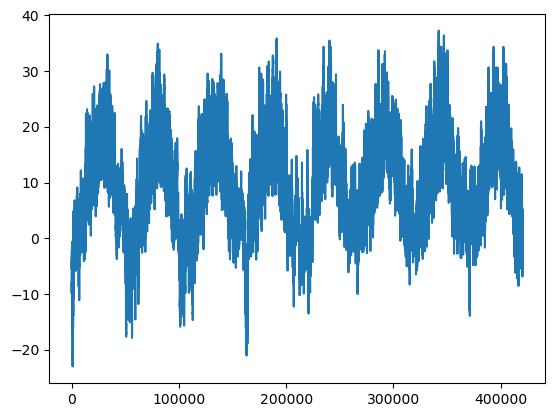

In [7]:
plt.plot(df[:, 2])

Khi xây dựng mô hình DL, ta cần chuẩn bị dữ liệu dưới dạng array

In [8]:
import os
fname = os.path.join("data/climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
# Tên các cột
header = lines[0].split(",")
# Giá trị của các biến (từ dòng số 1)
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Phân tách giá trị của dữ liệu dựa vào dựa vào `temperature` và các biến đầu vào

In [9]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [10]:
temperature

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [11]:
raw_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

Phân chia train & test

In [12]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [13]:
# Chuẩn hóa dữ liệu
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Với tập dữ liệu về nhiệt độ, mục tiêu dự báo nhiệt độ theo mỗi giờ. Dữ liệu gốc được ghi nhận mỗi 10 phút 1 lần. Do đó, ta chỉ cần lấy sample của mỗi giờ trong dữ liệu dự báo.

- `sampling_rate = 6`: Với mỗi khung giờ lấy 1 quan sát
- `sequence_length = 120`: Sử dụng 120 quan sát trước để dự báo (5 ngày dữ liệu = 24 * 5)
- `delay = sampling_rate * (sequence_length + 24 - 1)`: Dự báo 24h sau khi sequence kết thúc

In [14]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [15]:
# Train data
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [16]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

Xây dựng mô hình đơn giản

In [17]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [18]:

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [19]:
history = model.fit(train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/10


2025-01-03 08:37:00.050278: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2025-01-03 08:37:00.050357: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
	 [[{{function_node __inference_one_step_on_data_1179}}{{node functional_1/flatten_1/Reshape}}]]


InvalidArgumentError: Graph execution error:

Detected at node functional_1/flatten_1/Reshape defined at (most recent call last):
  File "/opt/saturncloud/envs/saturn/lib/python3.11/runpy.py", line 198, in _run_module_as_main

  File "/opt/saturncloud/envs/saturn/lib/python3.11/runpy.py", line 88, in _run_code

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/saturncloud/envs/saturn/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/opt/saturncloud/envs/saturn/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/opt/saturncloud/envs/saturn/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_243/2161284880.py", line 1, in <module>

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 110, in one_step_on_data

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 56, in train_step

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/models/functional.py", line 182, in call

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/models/functional.py", line 632, in call

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 4761, in reshape

  File "/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 1885, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node functional_1/flatten_1/Reshape}}]] [Op:__inference_multi_step_on_iterator_1212]

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")